In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def find_ID_coeffs_via_iterated_leastsq(A, J, notJ=None):
    """
    Given a set of columns A[:, J], finds a matrix Z such that
    approximately A = A[:, J] @ Z by iteratively solving for
    each column A[:, J] @ Z[:, j] = A[:, j] with least squares.
    """
    # number of columns
    _, N = A.shape
    # fill empty matrix with solutions
    Z = np.zeros((len(J), N), dtype=A.dtype)
    # set columns J to identity in Z
    Z[np.arange(len(J)), J] = 1.
    # for the rest solve A[:, J] @ x = A[:, j] for x, then Z[:, j] = x
    if notJ is None:
        notJ = list(set(range(N)) - set(J))

    #linalg.lstsq(a,b) Computes the vector x that approximately solves the equation a @ x = b
    x = np.linalg.lstsq(A[:, J], A[:, notJ], rcond=None)[0] # x.shape = (len(J), N)
    Z[:, notJ] = x
    return Z

In [ ]:
# this version of the TCI only keeps track of pivots and creates the actual MPS tensors only in the final sweep

def accumulative_tensor_cross_interpolation(tensor, L, d=2, sweeps=10):
    # initial choice is all zeros
    idxs = np.zeros((L,), dtype=np.int32)
    J = [idxs[j:].reshape(1, -1) for j in range(1, L+1)]
    I = [idxs[:j].reshape(1, -1) for j in range(L)]
    dtype = tensor(*idxs).dtype
    # sweep
    I = left_to_right_sweep(tensor, I, J, L, d, dtype)
    for i in range(sweeps-1):
        J = right_to_left_sweep(tensor, I, J, L, d, dtype)
        I = left_to_right_sweep(tensor, I, J, L, d, dtype)
    As = get_MPS_right_to_left_sweep(tensor, I, J, L, d, dtype)
    return As, I, J

def left_to_right_sweep(tensor, I, J, L, d, dtype):
    # sweep left to right
    for bond in range(L-1):
        if len(I[bond]) * d == len(I[bond+1]): # check if number of rows is already saturated
            pass
        else:
            # construct local two-site tensor
            chil, _ = I[bond].shape
            chir, _ = J[bond+1].shape
            Pi = np.zeros((chil, d, d, chir), dtype=dtype)
            for i, I1 in enumerate(I[bond]):
                for s1 in range(d):
                    for s2 in range(d):
                        for j, J2 in enumerate(J[bond+1]):
                            Pi[i, s1, s2, j] = tensor(*I1, s1, s2, *J2)
            Pi = Pi.reshape(chil * d, d * chir)

            # all rows of Pi = I[bond] x {0, ..., d-1}
            # Expands I[bond] by adding a new column with values [0, 1, ..., d-1].
            # Repeats this d times and stacks the results vertically.
            # If I[bond] has shape (chil, n), the resulting all_idxs has shape (chil * d, n + 1).
            all_idxs = np.concatenate(
                           [np.append(I[bond],
                                      s1 * np.ones((chil, 1), dtype=np.int32),
                                      axis=1)
                            for s1 in range(d)],
                           axis=0)


            # turn multi-indices I[bond+1] c I[bond] x {0, ..., d-1} into numbered indexes:
            #I[bond+1][:, None] has shape (m, 1, k)
            #all_idxs[None] has shape (1, n, k)

            #(I[bond+1][:, None] == all_idxs[None]) yields boolean array of shape (m, n, k)
            #Element at position (i, j, k) tells us whether element k in row i of I[bond+1] 
            # matches element k in row j of all_idxs

            # applying .all(axis=2) checks if all elements in rows i,j match
            # thus, collapsing boolean array (m,n,k) -> (m,n) where we have "True" at position i,j 
            # IF row i of I[bond+1] = row j of all_idxs
            
            #Applying np.argmax(..., axis=1) Finds the index of the first True value along each row (axis=1)

            #e.g. below!!
            I2 = list(np.argmax((I[bond+1][:, None] 
                                == all_idxs[None]).all(axis=2),
                                axis=1))

            # update index set I2
            N = Pi.shape[0]
            notI2 = list(set(range(N)) - set(I2)) # get indices not in I2
            # get current iteration for Pi_tilde from ID with rows in I2
            Z = find_ID_coeffs_via_iterated_leastsq(Pi.T, J=I2, notJ=notI2)
            Pi_tilde = Z.T @ Pi[I2, :]
            # compute errors and update index set
            errs = np.linalg.norm(Pi[notI2, :] - Pi_tilde[notI2, :], axis=1) # row errors
            ell = notI2[np.argmax(errs)]
            I[bond+1] = np.append(I[bond+1],
                                  all_idxs[None, ell],
                                  axis=0)
    return I

def right_to_left_sweep(tensor, I, J, L, d, dtype):
    # sweep right to left
    for bond in range(L-2,-1,-1):
        if len(J[bond]) == d * len(J[bond+1]): # check if number of columns is already saturated
            pass
        else:
            # construct local two-site tensor
            chil, _ = I[bond].shape
            chir, _ = J[bond+1].shape
            Pi = np.zeros((chil, d, d, chir), dtype=dtype)
            for i, I1 in enumerate(I[bond]):
                for s1 in range(d):
                    for s2 in range(d):
                        for j, J2 in enumerate(J[bond+1]):
                            Pi[i, s1, s2, j] = tensor(*I1, s1, s2, *J2)
            Pi = Pi.reshape(chil * d, d * chir)
            # all columns of Pi = {0, ..., d-1} x J[bond+1]
            all_idxs = np.concatenate(
                           [np.append(s2 * np.ones((chir, 1), dtype=np.int32),
                                      J[bond+1],
                                      axis=1)
                            for s2 in range(d)],
                           axis=0)
            # turn multi-indices J[bond] c {0, ..., d-1} x J[bond+1] into numbered indexes
            J1 = list(np.argmax((J[bond][:, None] == all_idxs[None]).all(axis=2),
                                axis=1))
            # update index set J1
            N = Pi.shape[1]
            notJ1 = list(set(range(N)) - set(J1)) # get indices not in J1
            # get current iteration for Pi_tilde from ID with columns in J1
            Z = find_ID_coeffs_via_iterated_leastsq(Pi, J=J1, notJ=notJ1)
            Pi_tilde = Pi[:, J1] @ Z
            # compute errors and update index set
            errs = np.linalg.norm(Pi[:, notJ1] - Pi_tilde[:, notJ1], axis=0) # column errors
            ell = notJ1[np.argmax(errs)]
            J[bond] = np.append(J[bond],
                                all_idxs[None, ell],
                                axis=0)
    return J

def get_MPS_right_to_left_sweep(tensor, I, J, L, d, dtype):
    # create list of MPS tensors to be filled
    As = [None for _ in range(L)]
    # sweep right to left
    for bond in range(L-2,-1,-1):
        # construct local two-site tensor
        chil, _ = I[bond].shape
        chir, _ = J[bond+1].shape
        Pi = np.zeros((chil, d, d, chir), dtype=dtype)
        for i, I1 in enumerate(I[bond]):
            for s1 in range(d):
                for s2 in range(d):
                    for j, J2 in enumerate(J[bond+1]):
                        Pi[i, s1, s2, j] = tensor(*I1, s1, s2, *J2)
        Pi = Pi.reshape(chil * d, d * chir)
        # all columns of Pi = {0, ..., d-1} x J[bond+1]
        all_idxs = np.concatenate(
                       [np.append(s2 * np.ones((chir, 1), dtype=np.int32),
                                  J[bond+1],
                                  axis=1)
                        for s2 in range(d)],
                       axis=0)
        # turn multi-indices J[bond] c {0, ..., d-1} x J[bond+1] into numbered indexes
        J1 = list(np.argmax((J[bond][:, None] == all_idxs[None]).all(axis=2),
                            axis=1))
        # only update the index set if the number of columns is not saturated
        if len(J[bond]) == d * len(J[bond+1]):
            pass
        else:
            # update index set J1
            N = Pi.shape[1]
            notJ1 = list(set(range(N)) - set(J1)) # get indices not in J1
            # get current iteration for Pi_tilde from ID with columns in J1
            Z = find_ID_coeffs_via_iterated_leastsq(Pi, J=J1, notJ=notJ1)
            Pi_tilde = Pi[:, J1] @ Z
            # compute errors and update index set
            errs = np.linalg.norm(Pi[:, notJ1] - Pi_tilde[:, notJ1], axis=0) # column errors
            ell = notJ1[np.argmax(errs)]
            J1.append(ell)
            J[bond] = np.append(J[bond],
                                all_idxs[None, ell],
                                axis=0)
        # construct MPS tensor from index set
        Z = find_ID_coeffs_via_iterated_leastsq(Pi, J=J1)
        As[bond+1] = Z.reshape(len(J1), d, chir)
    # last tensor is slice
    As[0] = Pi[:, J1].reshape(chil, d, len(J1))
    return As

In [4]:
#e.g. on use of I2 = list(np.argmax((I[bond+1][:, None] == all_idxs[None]).all(axis=2), axis=1))

I[bond+1] = np.array([[1, 2], [3, 4]])  # shape (2,2)
all_idxs  = np.array([[1, 2], [5, 6], [3, 4]])  # shape (3,2)

# executing (I[bond+1][:, None] == all_idxs[None])

array([
   [[ True,  True],  # [1,2] == [1,2]
    [False, False],  # [1,2] != [5,6]
    [False, False]], # [1,2] != [3,4]

   [[False, False],  # [3,4] != [1,2]
    [False, False],  # [3,4] != [5,6]
    [ True,  True]]  # [3,4] == [3,4]
])

#applying .all(axis=2) we get

array([
   [ True, False, False],  # First row matches first row in all_idxs
   [False, False,  True]   # Second row matches third row in all_idxs
])

#Finally, np.argmax(..., axis=1) finds the first True in each row:

I2 = [0, 2]  # First row of I[bond+1] maps to index 0 in all_idxs, second row maps to index 2.


NameError: name 'I' is not defined

In [ ]:
# this version of the TCI updates the MPS tensors along the way and moves the 'canonical' center, i.e., the slice of the dense tensor

def accumulative_tensor_cross_interpolation_v2(tensor, L, d=2, sweeps=10):
    # initial choice is all zeros
    idxs = np.zeros((L,), dtype=np.int32)
    As = [np.array([[[tensor(*idxs[:j], i, *idxs[j+1:])] for i in range(d)]])
          for j in range(L)]
    if As[0][0,0,0] != 0:
        As[1:] /= tensor(*idxs)
    J = [idxs[j:].reshape(1, -1) for j in range(1, L+1)]
    I = [idxs[:j].reshape(1, -1) for j in range(L)]
    dtype = As[0].dtype
    # sweep
    for i in range(sweeps):
        As, I = left_to_right_sweep_v2(tensor, As, I, J, L, d, dtype)
        As, J = right_to_left_sweep_v2(tensor, As, I, J, L, d, dtype)
    return As, I, J

def left_to_right_sweep_v2(tensor, As, I, J, L, d, dtype):
    # sweep left to right
    for bond in range(L-1):
        # construct exact local two-site tensor
        chil, _ = I[bond].shape
        chir, _ = J[bond+1].shape
        Pi = np.zeros((chil, d, d, chir), dtype=dtype)
        for i, I1 in enumerate(I[bond]):
            for s1 in range(d):
                for s2 in range(d):
                    for j, J2 in enumerate(J[bond+1]):
                        Pi[i, s1, s2, j] = tensor(*I1, s1, s2, *J2)
        Pi = Pi.reshape(chil * d, d * chir)
        # all rows of Pi = I[bond] x {0, ..., d-1}
        all_idxs = np.concatenate(
                       [np.append(I[bond],
                                  s1 * np.ones((chil, 1), dtype=np.int32),
                                  axis=1)
                        for s1 in range(d)],
                       axis=0)
        # turn multi-indices I[bond+1] c I[bond] x {0, ..., d-1} into numbered indexes
        I2 = list(np.argmax((I[bond+1][:, None] == all_idxs[None]).all(axis=2),
                            axis=1))
        # update index set I2
        N = Pi.shape[0]
        notI2 = list(set(range(N)) - set(I2)) # get indices not in I2
        if len(I[bond+1]) == N:
            pass # don't add a row if set of rows is already maximal
        else:
            # get current iteration for Pi_tilde from MPS
            Pi_tilde = np.einsum('aib, bjc -> aijc', As[bond], As[bond+1])
            Pi_tilde = Pi_tilde.reshape(Pi.shape)
            # compute errors and update index set
            errs = np.linalg.norm(Pi[notI2, :] - Pi_tilde[notI2, :], axis=1) # row errors
            ell = notI2[np.argmax(errs)]
            I2.append(ell)
            notI2.remove(ell)
            I[bond+1] = np.append(I[bond+1],
                                  all_idxs[None, ell],
                                  axis=0)
        # shift canonicality center by ID with updated index set
        Z = find_ID_coeffs_via_iterated_leastsq(Pi.T, J=I2, notJ=notI2)
        chi = len(I2)
        # update tensors
        As[bond] = Z.T.reshape(chil, d, chi)
        As[bond+1] = Pi[I2, :].reshape(chi, d, chir)
    return As, I

def right_to_left_sweep_v2(tensor, As, I, J, L, d, dtype):
    # sweep right to left
    for bond in range(L-2,-1,-1):
        # construct local two-site tensor
        chil, _ = I[bond].shape
        chir, _ = J[bond+1].shape
        Pi = np.zeros((chil, d, d, chir), dtype=dtype)
        for i, I1 in enumerate(I[bond]):
            for s1 in range(d):
                for s2 in range(d):
                    for j, J2 in enumerate(J[bond+1]):
                        Pi[i, s1, s2, j] = tensor(*I1, s1, s2, *J2)
        Pi = Pi.reshape(chil * d, d * chir)
        # all columns of Pi = {0, ..., d-1} x J[bond+1]
        all_idxs = np.concatenate(
                       [np.append(s2 * np.ones((chir, 1), dtype=np.int32),
                                  J[bond+1],
                                  axis=1)
                        for s2 in range(d)],
                       axis=0)
        # turn multi-indices J[bond] c {0, ..., d-1} x J[bond+1] into numbered indexes
        J1 = list(np.argmax((J[bond][:, None] == all_idxs[None]).all(axis=2),
                            axis=1))
        # update index set J1
        N = Pi.shape[1]
        notJ1 = list(set(range(N)) - set(J1)) # get indices not in J1
        if len(J[bond]) == N:
            pass # don't add a column if set of columns is already maximal
        else:
            # get current iteration for Pi_tilde from MPS
            Pi_tilde = np.einsum('aib, bjc -> aijc', As[bond], As[bond+1])
            Pi_tilde = Pi_tilde.reshape(Pi.shape)
            # compute errors and update index set
            errs = np.linalg.norm(Pi[:, notJ1] - Pi_tilde[:, notJ1], axis=0) # column errors
            ell = notJ1[np.argmax(errs)]
            J1.append(ell)
            notJ1.remove(ell)
            J[bond] = np.append(J[bond],
                                all_idxs[None, ell],
                                axis=0)
        # shift canonicality center by ID with updated index set
        Z = find_ID_coeffs_via_iterated_leastsq(Pi, J=J1, notJ=notJ1)
        chi = len(J1)
        # update tensors
        As[bond] = Pi[:, J1].reshape(chil, d, chi)
        As[bond+1] = Z.reshape(chi, d, chir)
    return As, J

TCI while only updating the index sets  took 6.017s.
TCI while also updating the MPS tensors took 6.854s.


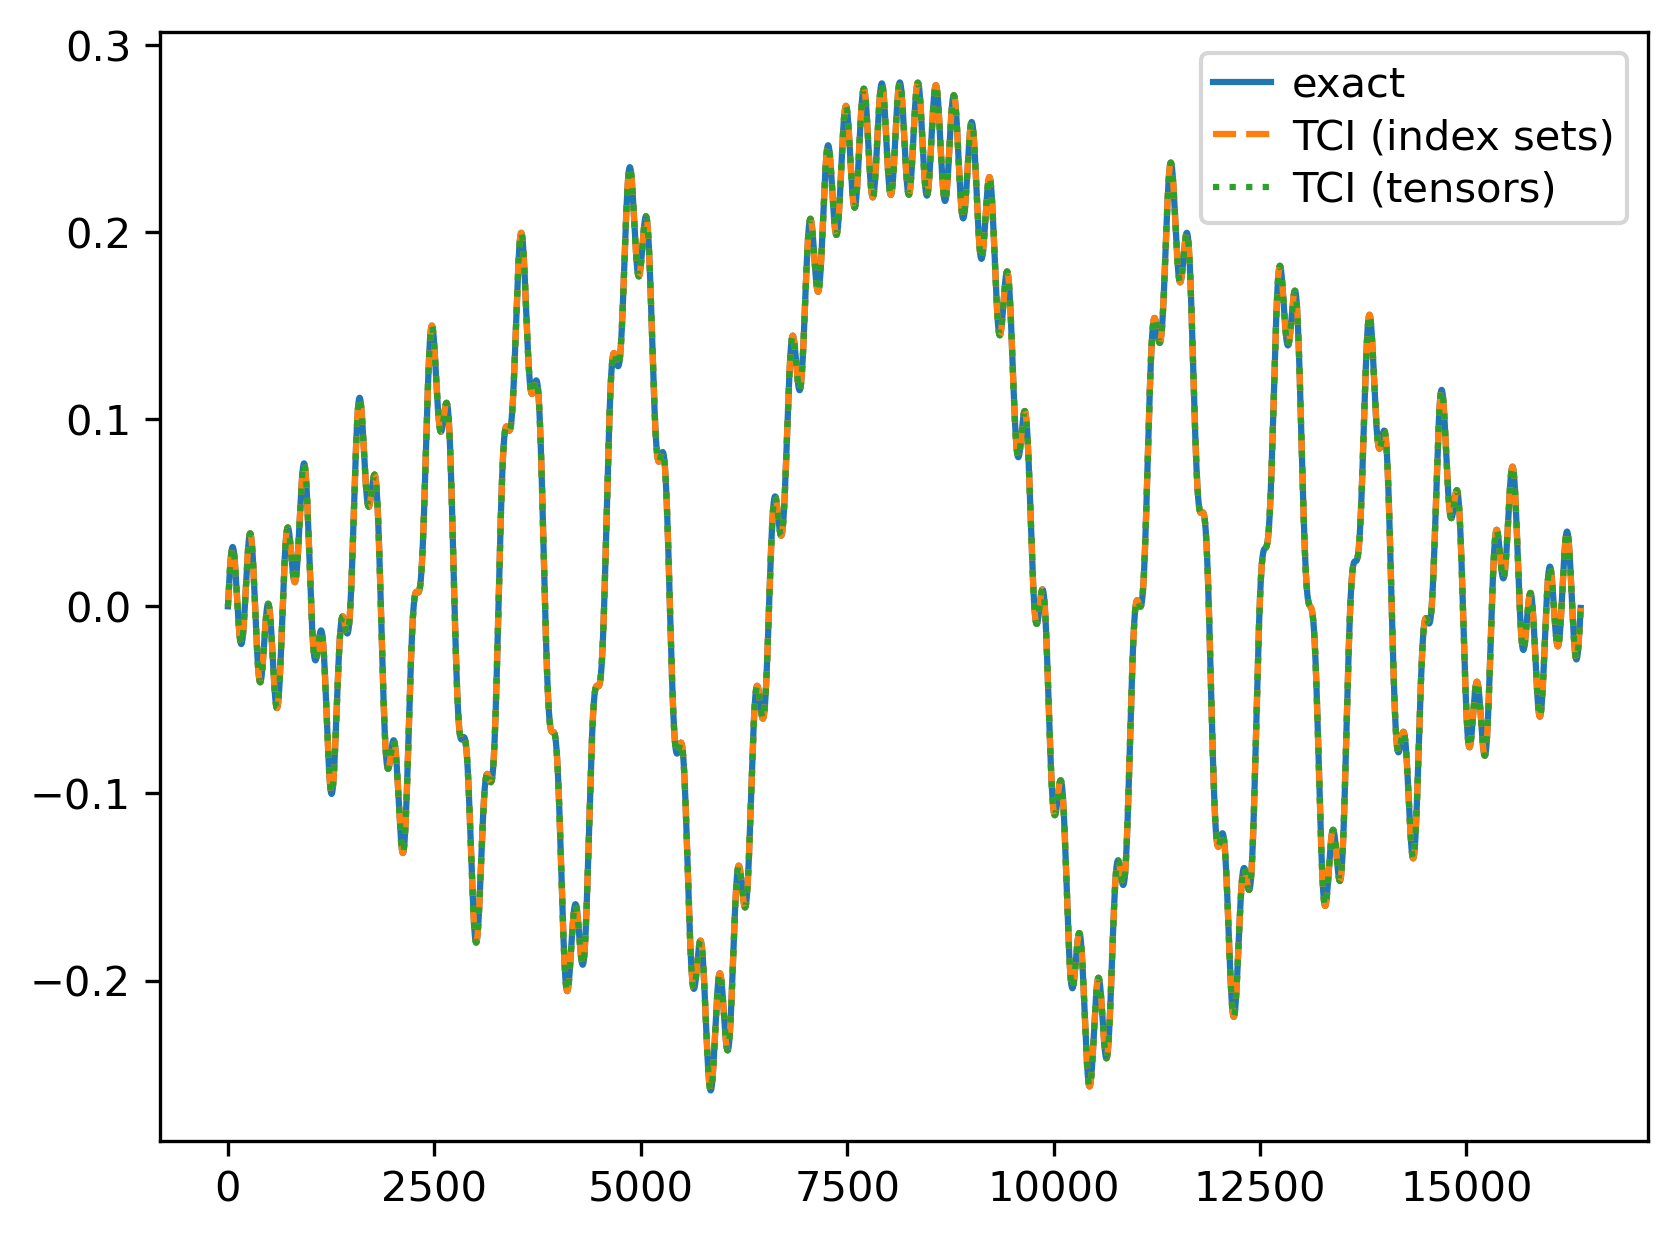

In [6]:
# toy example to compare speed

# maybe you want to reduce these two parameters
L = 14
sweeps = 40

def func(*args):
    x = np.sum(np.array(args) * 2.**np.arange(-1, -L-1, -1))
    y = np.sin(50*np.pi * x * (1 - x)) * x * (1 - x)
    y += 0.03 * np.sin(150 * np.pi * x)
    return y

sigmas = np.array([[(i // 2**j) % 2 for j in range(L-1,-1,-1)] for i in range(2**L)])
fvals = [func(sigma) for sigma in sigmas]

start = time.time()
As1, I1, J1 = accumulative_tensor_cross_interpolation(func, L, sweeps=sweeps)
t1 = time.time() - start

start = time.time()
As2, I2, J2 = accumulative_tensor_cross_interpolation_v2(func, L, sweeps=sweeps)
t2 = time.time() - start

def contract_MPS(As):
    vals = np.squeeze(As[0])
    for A in As[1:]:
        vals = np.einsum('ia, ajb -> ijb', vals, A)
        vals = vals.reshape(-1, A.shape[-1])
    vals = vals.reshape(-1)
    return vals

ivals1 = contract_MPS(As1)
ivals2 = contract_MPS(As2)

print(f'TCI while only updating the index sets  took {t1:.3f}s.')
print(f'TCI while also updating the MPS tensors took {t2:.3f}s.')

fig, ax = plt.subplots(dpi=300)
ax.plot(fvals, '-', label='exact')
ax.plot(ivals1, '--', label='TCI (index sets)')
ax.plot(ivals2, ':', label='TCI (tensors)')
ax.legend(loc='upper right',
          handlelength=1.4,
          borderpad=0.3,
          labelspacing=0.3,
          handletextpad=0.5)
plt.show()